# **Initial Steps**

In [0]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.integrate import odeint

from scipy.integrate import odeint
!pip install lmfit
import lmfit
from lmfit.lineshapes import gaussian, lorentzian

!git clone https://github.com/abijbart/DS4H_covid19.git
dataset_dir = 'DS4H_covid19/dataset/cleaned'

fatal: destination path 'DS4H_covid19' already exists and is not an empty directory.


In [0]:
dataset_dir = 'DS4H_covid19/dataset/cleaned/'
novel_df = pd.read_csv(dataset_dir + 'Novel_coronavirus_dataset.csv')
hospital_beds_df = pd.read_csv(dataset_dir + 'hospital_beds.csv')
italy_df = pd.read_csv(dataset_dir + 'italy_regional.csv')
korea_df = pd.read_csv(dataset_dir + 'south_korea.csv')
switzerland_df = pd.read_csv(dataset_dir + 'switzerland.csv')
usa_df = pd.read_csv(dataset_dir + 'usa.csv')

# Fitting our mode 

# First implementation of the model
## Basic implemention

#**Scratch**

Switzerland population 2018 = 8,516,543

In [0]:
population = 8,516,543


In [0]:
switzerland_df

,Unnamed: 0,Date,TotalPositiveCases,Deaths,TotalHospitalizedPatients,IntensiveCarePatients,Recovered
0,0,2020-03-06,416,0,57,2,2
1,1,2020-03-07,526,0,56,1,1
2,2,2020-03-08,656,0,77,1,1
3,3,2020-03-09,752,1,109,6,6
4,4,2020-03-10,1010,2,135,14,14
5,5,2020-03-11,1280,2,177,19,19
6,6,2020-03-12,1760,2,197,21,21
7,7,2020-03-13,2410,5,380,31,31
8,8,2020-03-14,3214,11,319,28,28
9,9,2020-03-15,3339,17,358,30,30


# **SEIR Model** 

**vars**:

y = model with SEIR

t = time

S = susceptible

E = exposed

I = Infected

R = Recovered

H = Hospitalized

C = Critical Care

beta = expected amount of people an infected person infects per day

p = proportion of infections

gamma = 1 / period prior to hospitalization

delta = 1 / hospitalization duration

zeta = 1/ period in critical care prior to recovery

nu = rate of infection



In [0]:
def seir_deriv(y, t, nu, population,
              # prob_ItoR, prob_ItoH, prob_HtoR, prob_HtoC, prob_CtoR,
               p_R, p_H, p_C, 
               beta, gamma, delta_H, delta_C, zeta):
  S, E, I_R, I_H, I_C, R_R, R_H, R_C, H_H, H_C, C = y
  I = I_R + I_H + I_C

  dSdt = -beta(t) * I * S / population
  dEdt = beta(t) * I * S / population - nu * p_R * E - nu * p_H * E - nu * p_C * E 
  dIdt_R = nu * p_R * E - gamma * I_R
  dIdt_H = nu * p_H * E - gamma * I_H - delta_H * H_H 
  dIdt_C = nu * p_C * E - gamma * I_C - delta_C * H_C - zeta * C
  
  
  #dRdt_R = gamma * prob_ItoR * I_R
  dRdt_R = gamma * I_R

  # dHdt_H = gamma * prob_ItoH * I_H - delta_H * prob_HtoR * H_H
  # dRdt_H = delta_H * prob_HtoR * H_H

  dHdt_H = gamma * I_H - delta_H * H_H
  dRdt_H = delta_H * H_H

  # dHdt_C = gamma * prob_ItoH * I_C - delta_C * H_C - zeta * prob_CtoR * C
  # dCdt = delta_C * prob_HtoC *  H_C - zeta * prob_CtoR * C
  # dRdt_C = zeta * prob_CtoR * C

  dHdt_C = gamma * I_C - delta_C * H_C - zeta * C
  dCdt = delta_C *  H_C - zeta * C
  dRdt_C = zeta * C
    
  return dSdt, dEdt, dIdt_R, dIdt_H, dIdt_C, dRdt_R, dRdt_H, dRdt_C, dHdt_H, dHdt_C, dCdt


In [0]:
N_sw = 8516543
N_it = 60431283
N_us = 327167434
N_sk = 51635256

In [0]:
def model_by_country(pop):
  gamma = 1.0/5.0
  p_R, p_H, p_C, nu = 0.9, 0.05, 0.05, 1.0/5.2 
  S, E, I_R, I_H, I_C, R_R, R_H, R_C, H_H, H_C, C = N_sw-1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0 
  delta_H = 1.0/8.0
  delta_C = 1.0/6.0
  zeta = 1.0/10.0 
  R_0 = 2.2

  def beta(t):
    return R_0*t*gamma

  t = np.linspace(0, 250, 250) # Grid of time points (in days)
  y0 = S, E, I_R, I_H, I_C, R_R, R_H, R_C, H_H, H_C, C # Initial conditions vector
  # Integrate the SIR equations over the time grid, t.
  ret = odeint(seir_deriv, y0, t, args=(nu, pop, p_R, p_H, p_C, beta, gamma, delta_H, delta_C, zeta))
  dSdt, dEdt, dIdt_R, dIdt_H, dIdt_C, dRdt_R, dRdt_H, dRdt_C, dHdt_H, dHdt_C, dCdt = ret.T 
  S, E, I, R, H, C = dSdt, dEdt, (dIdt_R + dIdt_H + dIdt_C), (dRdt_R+dRdt_H+dRdt_C), (dHdt_H + dHdt_C), dCdt
  return t, S, E, I, R, H, C

In [0]:
def plotseirhc(t, S, E, I, R, H, C):
  f, ax = plt.subplots(1,1,figsize=(10,4))
  ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
  ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
  ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
  ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
  ax.plot(t, H, 'k', alpha=0.7, linewidth=2, label='Hospitalized')
  ax.plot(t, C, 'm', alpha=0.7, linewidth=2, label='Critical Care')
  ax.plot(t, S+E+I+R+H+C, 'c--', alpha=0.7, linewidth=2, label='Total')

  ax.set_xlabel('Time (days)')

  ax.yaxis.set_tick_params(length=0)
  ax.xaxis.set_tick_params(length=0)
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')
  legend = ax.legend()
  legend.get_frame().set_alpha(0.5)
  for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)
  plt.show();
hospital_beds_df

,LOCATION,Hospital Beds per 1000 habitants
0,Italy,3.17
1,Korea,11.98
2,Switzerland,4.55
3,USA,2.77


## **Switzerland**

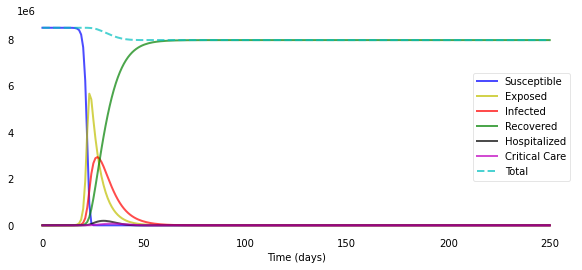

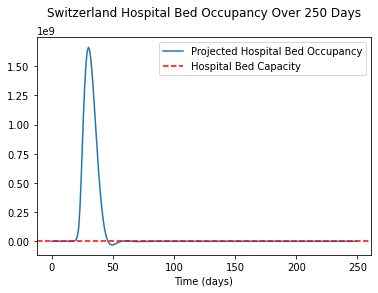

In [0]:
t, S, E, I, R, H, C = model_by_country(N_sw)
plotseirhc(t, S, E, I, R, H, C)
norm_H = H * N_sw / 1000
beds_sw = hospital_beds_df[hospital_beds_df['LOCATION'] == 'Switzerland']['Hospital Beds per 1000 habitants']
plt.plot(norm_H, label='Projected Hospital Bed Occupancy')
plt.axhline(y=int(beds_sw), color='r', linestyle='--', label='Hospital Bed Capacity')
plt.legend()
plt.title('Switzerland Hospital Bed Occupancy Over 250 Days\n')
plt.xlabel('Time (days)')
plt.show()

## **Italy**

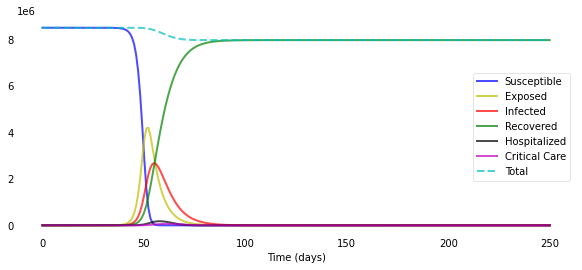

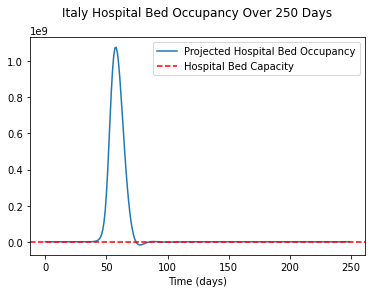

In [0]:
t, S, E, I, R, H, C = model_by_country(N_it)
plotseirhc(t, S, E, I, R, H, C)
norm_H = H * N_it / 10000  
beds_it = hospital_beds_df[hospital_beds_df['LOCATION'] == 'Italy']['Hospital Beds per 1000 habitants']
plt.plot(norm_H, label='Projected Hospital Bed Occupancy')
plt.axhline(y=int(beds_it), color='r', linestyle='--', label='Hospital Bed Capacity')
plt.legend()
plt.title('Italy Hospital Bed Occupancy Over 250 Days\n')
plt.xlabel('Time (days)')
plt.show()

## **USA**

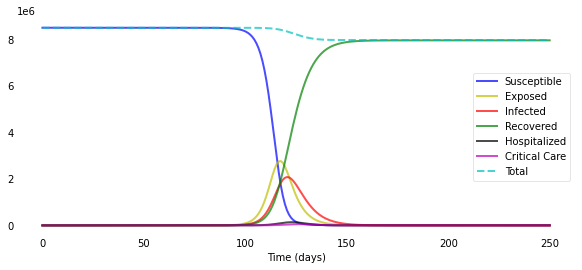

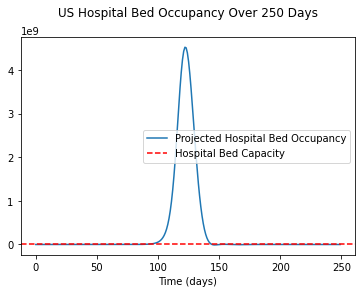

In [0]:
t, S, E, I, R, H, C = model_by_country(N_us)
plotseirhc(t, S, E, I, R, H, C)
norm_H = H * N_us / 10000  
beds_us = hospital_beds_df[hospital_beds_df['LOCATION'] == 'USA']['Hospital Beds per 1000 habitants']
plt.plot(norm_H, label='Projected Hospital Bed Occupancy')
plt.axhline(y=int(beds_us), color='r', linestyle='--', label='Hospital Bed Capacity')
plt.legend()
plt.title('US Hospital Bed Occupancy Over 250 Days\n')
plt.xlabel('Time (days)')
plt.show()

## **South Korea** 

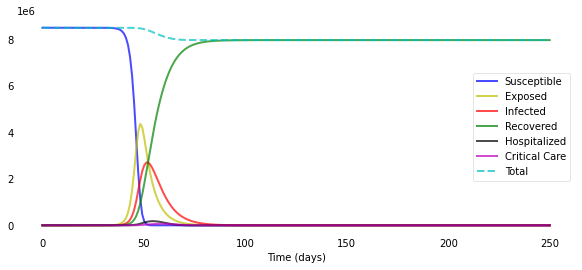

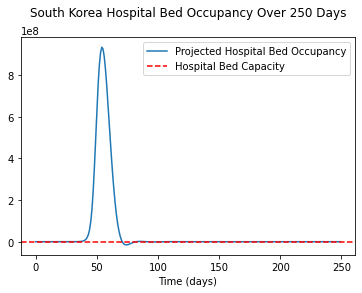

In [0]:
t, S, E, I, R, H, C = model_by_country(N_sk)
plotseirhc(t, S, E, I, R, H, C)
norm_H = H * N_sk / 10000  
beds_sk = hospital_beds_df[hospital_beds_df['LOCATION'] == 'Korea']['Hospital Beds per 1000 habitants']
plt.plot(norm_H, label='Projected Hospital Bed Occupancy')
plt.axhline(y=int(beds_sk), color='r', linestyle='--', label='Hospital Bed Capacity')
plt.legend()
plt.title('South Korea Hospital Bed Occupancy Over 250 Days\n')
plt.xlabel('Time (days)')
plt.show()

I think we need probabilities for infected->recovery, infected->hospital, hospital->critical, hospital->recovery

Taken from Kissler et al. implementation numbers, informed by Ferguson et al. 



Calculate probabilities: 
  * P(infected->recovery) 
  * P(infected->hospital)
  * P(hospital->critical)
  * P(hospital->recovery)
  * P(critical->recovery)



#**Normalize Predictions**


In [0]:
def normalize_bed(bed, pop):
  return (bed / pop) * 10000

In [0]:
def normalize_icu(criticalcare, population):
  return (criticalcare / population) * 10000

#**Evaluate Demand**

AJB: suddenly worried that this equation does not make sense


In [0]:
def bed_demand(bed_utilization, normalized_bed):
  return bed_utilization * normalized_bed

#**Countries**

In [0]:
korea_df.columns

Index(['Unnamed: 0', 'Date', 'TotalPositiveCases', 'NewPositiveCases',
       'Deaths', 'Recovered', 'HospitalizedPatients',
       'TotalHospitalizedPatients'],
      dtype='object')

In [0]:
switzerland_df.columns

Index(['Unnamed: 0', 'Date', 'TotalPositiveCases', 'Deaths',
       'TotalHospitalizedPatients', 'IntensiveCarePatients', 'Recovered'],
      dtype='object')

In [0]:
usa_df.columns


Index(['Unnamed: 0', 'Date', 'HospitalizedPatients',
       'TotalHospitalizedPatients', 'IntensiveCarePatients', 'Recovered',
       'Deaths', 'TestsPerformed'],
      dtype='object')

TODO: clean italy... compress regions so that it matches format of other countries

In [0]:
italy_df_compressed = pd.DataFrame()
italy_df_compressed['Date'] = italy_df.Date.unique()
hosp = []
tot_hosp= []
icu = []
rec = []
dead = []
for d in italy_df.Date.unique():
  hosp.append(sum(italy_df[italy_df.Date == d]['HospitalizedPatients']))
  tot_hosp.append(sum(italy_df[italy_df.Date == d]['TotalHospitalizedPatients']))
  icu.append(sum(italy_df[italy_df.Date == d]['IntensiveCarePatients']))
  rec.append(sum(italy_df[italy_df.Date == d]['Recovered']))
  dead.append(sum(italy_df[italy_df.Date == d]['Deaths']))
italy_df_compressed['HospitalizedPatients'] = hosp
italy_df_compressed['TotalHospitalizedPatients'] = tot_hosp
italy_df_compressed['IntensiveCarePatients'] = icu
italy_df_compressed['Recovered'] = rec
italy_df_compressed['Deaths'] = dead